# LBM tutorial

## hello world 

 - First we will assume that there is a current version of a sailfish in current directory.
 
         !git clone https://github.com/sailfish-team/sailfish
         
### Notes on using sailfish in jupyter notebook:

- we will write script in data subdirectory, using %writefile magic
- the script will be executed by %sh magic
- output will be put in data subdirectory
- notebook is used for data processing and experimentation

Running saifish code in the notebook is possible if one turns on --debug_ single process

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys, os
sys.path.append('./sailfish/')

datapath = os.path.join( "/dev/shm/",os.environ.get("USER"),"data")
try:
    os.makedirs(datapath,mode=0755)
except OSError as ex:
    print datapath,"::",ex.strerror

if not os.path.isdir('data') and os.path.islink('data'):
    os.remove("data")
    
if not os.path.islink('data'):
    os.symlink(datapath, "data")


/dev/shm/marcin.kostur/data :: File exists


In [2]:
%%sh 
pwd

/home/users/marcin.kostur/LBM_tutorial


In [3]:
%%sh
cd sailfish
git pull 

Already up-to-date.


In [4]:
!git clone https://github.com/marcinofulus/sailfish

fatal: destination path 'sailfish' already exists and is not an empty directory.


In [5]:
%%writefile data/ex1.py
import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTFullBBWall, NTEquilibriumVelocity
from sailfish.controller import LBSimulationController
from sailfish.lb_single import LBFluidSim

class MyBlock(Subdomain2D):
    max_v = 0.1

    def boundary_conditions(self, hx, hy):
        wall_map = ( (hx == self.gx-1) | (hx == 0) | (hy == 0) )
        self.set_node( (hy == self.gy-1) & (hx>0) & (hx<self.gx-1) , NTEquilibriumVelocity((self.max_v, 0.0)) )
        self.set_node(wall_map, NTFullBBWall)
        
    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0

class MySim(LBFluidSim):
    subdomain = MyBlock

LBSimulationController(MySim).run()

Overwriting data/ex1.py


The ex1.py program needs to know about the total number of iterations and the lattice size. It can be specified as the command line parameters.

Thus the simplest way to call this program is following:

In [6]:
%%sh
export PYTHONPATH=$PWD/sailfish/
python data/ex1.py --max_iters=100 --lat_nx=32 --lat_ny=48

[   750  INFO Master/GPU2] Machine master starting with PID 13144 at 2016-05-18 06:43:14 UTC
[   750  INFO Master/GPU2] Simulation started with: data/ex1.py --max_iters=100 --lat_nx=32 --lat_ny=48
[   757  INFO Master/GPU2] Sailfish version: dcc3d33d3c6fe420f78ff1af13471774ef283c74
[   757  INFO Master/GPU2] Handling subdomains: [0]
[   757  INFO Master/GPU2] Subdomain -> GPU map: {0: 0}
[   758  INFO Master/GPU2] Selected backend: cuda
[   994  INFO Subdomain/0] Initializing subdomain.
[   995  INFO Subdomain/0] Required memory: 
[   995  INFO Subdomain/0] . distributions: 0 MiB
[   996  INFO Subdomain/0] . fields: 0 MiB
[  2095  INFO Subdomain/0] Starting simulation.
[  2106  INFO Subdomain/0] Simulation completed after 100 iterations.


The last command has:
    
- prepared D2Q9 kernel in CUDA-C language,
- given initial conditions ($\rho$ and $\vec u$) as numpy arrays, initialized distributions on the device,
- run 100 iterations on 32x48 lattice in D2Q9 LBM model,
- quit without writing out any data

The standard output to the command reveals that computations has been done on a single device with identifier `0`. 
The sailfish version  means the hash from github repository (in this case: https://github.com/sailfish-team/sailfish).





If one wants to see more information about the simulation process then  can be seen when flag `verbose=1` is set. 


In [7]:
%%sh
export PYTHONPATH=$PWD/sailfish/
python data/ex1.py --max_iters=100 --lat_nx=32 --lat_ny=48 --verbose

[   844  INFO Master/GPU2] Machine master starting with PID 4204 at 2016-05-17 19:31:42 UTC
[   844  INFO Master/GPU2] Simulation started with: data/ex1.py --max_iters=100 --lat_nx=32 --lat_ny=48 --verbose
[   852  INFO Master/GPU2] Sailfish version: dcc3d33d3c6fe420f78ff1af13471774ef283c74
[   852  INFO Master/GPU2] Handling subdomains: [0]
[   852  INFO Master/GPU2] Subdomain -> GPU map: {0: 0}
[   852  INFO Master/GPU2] Selected backend: cuda
[   856 DEBUG Subdomain/0] SubdomainRunner starting with PID 4209
[  1080 DEBUG Master/GPU2] Port map is: {}
[  1081  INFO Subdomain/0] Initializing subdomain.
[  1081 DEBUG Subdomain/0] Tesla K40m / CC (3, 5) / MEM 12079136768
[  1081 DEBUG Subdomain/0] Initializing geometry.
[  1081 DEBUG Subdomain/0] Effective lattice size is: [64, 50]
[  1082 DEBUG Subdomain/0] Disabling bulk/boundary split.
[  1082 DEBUG Subdomain/0] Bulk grid: [1, 50]
[  1082 DEBUG Subdomain/0] Boundary grid: None
[  1082  INFO Subdomain/0] Required memory: 
[  1082  INFO

### Output

In the case of 2d simulation a very convenient format for fields on a regular lattice in a numpy array. We  can ask sailfish to write to numpy files with "casename" `ex1` in the directory `data` by:
  
  `--output=data/ex1 --output_format=npy`

Except debugging purposes it is not very efficient to store all macroscopic fields every simulation step. Current GPU devices can produce Terabytes of data in few seconds, thus they must be processed within a GPU device. The simple way to limit the output is to use:

 - `--from=123` - start output from  123-th iteration, when not given it starts from 0-th
 - `--every=100` - output every 100-th iteration, files will have a iteration number in a filename
 
 If we wanted to store the initial condition and the final step the following line should be executed:
  
   
   

In [7]:
%%sh
export PYTHONPATH=$PWD/sailfish/
python data/ex1.py --max_iters=1000 --every=1000 \
 --lat_nx=32 --lat_ny=48 \
 --output=data/ex1 --output_format=npy

[   755  INFO Master/GPU2] Machine master starting with PID 13402 at 2016-05-18 06:56:26 UTC
[   755  INFO Master/GPU2] Simulation started with: data/ex1.py --max_iters=1000 --every=1000 --lat_nx=32 --lat_ny=48 --output=data/ex1 --output_format=npy
[   767  INFO Master/GPU2] Sailfish version: dcc3d33d3c6fe420f78ff1af13471774ef283c74
[   767  INFO Master/GPU2] Handling subdomains: [0]
[   767  INFO Master/GPU2] Subdomain -> GPU map: {0: 0}
[   767  INFO Master/GPU2] Selected backend: cuda
[  1005  INFO Subdomain/0] Initializing subdomain.
[  1006  INFO Subdomain/0] Required memory: 
[  1007  INFO Subdomain/0] . distributions: 0 MiB
[  1007  INFO Subdomain/0] . fields: 0 MiB
[  4157  INFO Subdomain/0] Starting simulation.
[  4273  INFO Subdomain/0] Simulation completed after 1000 iterations.


We can look at  files with ex1 prefix in data directory:

In [8]:
!ls data/ex1* -rtla

-rw-r--r-- 1 marcin.kostur staff   451 May 11 13:49 data/ex1.0.000.npz
-rw-r--r-- 1 marcin.kostur staff 25709 May 11 13:49 data/ex1_dists.0.099.npz
-rw-r--r-- 1 marcin.kostur staff  8994 May 11 13:49 data/ex1.0.100.npz
-rw-r--r-- 1 marcin.kostur staff   705 May 18 08:43 data/ex1.py
-rw-r--r-- 1 marcin.kostur staff   586 May 18 08:56 data/ex1.subdomains
-rw-r--r-- 1 marcin.kostur staff   493 May 18 08:56 data/ex1.0.0000.npz
-rw-r--r-- 1 marcin.kostur staff 15113 May 18 08:56 data/ex1.0.1000.npz


The macroscopic fields are written to `numpy` files, so we could open them with `np.load` function. It contains self explanatory names of the fields:

In [9]:
data = np.load("data/ex1.0.1000.npz")
data.files

['rho', 'v']

In [14]:
np.nanmin(data['rho'])

0.78508025

Scalar fields are simply $48 \times 32$ arrays. The physial $x$-axis  corresponds to the fastest changing index in the numpy array (C-convention by default). Thus arrays used in sailfish are "xy"-indexing style (see http://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html)

Thus in matrix notation $a_{ij}$, or `a[i,j]`:

 * $x \iff j$
 * $y \iff i$

Vector field are stored component by component (SoA, not AoS), and have one axis more:

In [15]:
print data['rho'].shape
print data['v'].shape
print data['v'][0].shape

(48, 32)
(2, 48, 32)
(48, 32)


It is convenient to assign new variables for $x$ and $y$- component of the velocity:

In [17]:
vx,vy = data['v']
vy.shape

(48, 32)

One can retrieve from output data the size of the lattice, for example by:

In [18]:
ny,nx = vx.shape

then we can plot the ordered data using fast routine `imshow` (with no interpolation):

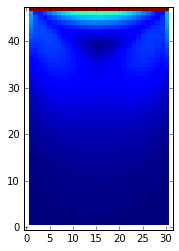

In [25]:
plt.imshow(np.sqrt(vx**2+vy**2),origin='top',interpolation='nearest')

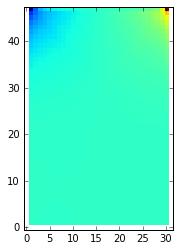

In [20]:
plt.imshow(data['rho'],origin='top',interpolation='nearest')

In [21]:
Y,X = np.mgrid[0:ny,0:nx]

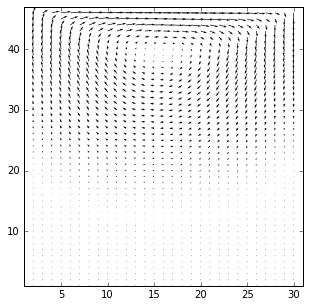

In [22]:
plt.figure(figsize=(5,5))
plt.xlim(1,nx-1)
plt.ylim(1,ny-1)
plt.quiver(X,Y,vx,vy)

In [23]:
vx.shape,X.shape


((48, 32), (48, 32))

In [39]:
vy[np.isnan(vy)] = 0.0
vx[np.isnan(vx)] = 0.0

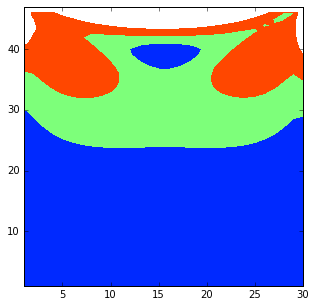

In [37]:
plt.figure(figsize=(5,ny/nx*5))
plt.xlim(1,nx-2)
plt.ylim(1,ny-1)
plt.contourf(X,Y,np.sqrt(vy**2+vx**2),np.linspace(0.,0.02,4))

In [31]:
plt.contourf?


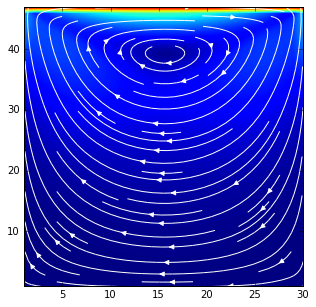

In [40]:
plt.figure(figsize=(5,ny/nx*5))
plt.xlim(1,nx-2)
plt.ylim(1,ny-1)

plt.contourf(X,Y,np.sqrt(vy**2+vx**2),256)
plt.streamplot(X,Y,vx,vy,color='white')


**Note:** the difference in default `mgrid` and `meshgrid`:

In [21]:
np.mgrid[0:4,0:4][0]

array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3]])

In [22]:
x = np.linspace(0,3,4)
X,Y = np.meshgrid(x,x)
X

array([[ 0.,  1.,  2.,  3.],
       [ 0.,  1.,  2.,  3.],
       [ 0.,  1.,  2.,  3.],
       [ 0.,  1.,  2.,  3.]])

In [41]:
%%writefile data/ex2.py
import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTFullBBWall, NTEquilibriumVelocity
from sailfish.controller import LBSimulationController
from sailfish.lb_single import LBFluidSim

class MyBlock(Subdomain2D):
    max_v = 0.1

    def boundary_conditions(self, hx, hy):
        wall_map = ( (hx == self.gx-1) | (hx == 0) | (hy == 0) )
        self.set_node( (hy == self.gy-1) & (hx>0) & (hx<self.gx-1) , NTEquilibriumVelocity((self.max_v, 0.0)) )
        self.set_node(wall_map, NTFullBBWall)
        np.savez("data/hx.npz",hx=hx,hy=hy)
    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0
        
class MySim(LBFluidSim):
    subdomain = MyBlock

LBSimulationController(MySim).run()

Overwriting data/ex2.py


In [42]:
%%sh
export PYTHONPATH=$PWD/sailfish/
python data/ex2.py --max_iters=100 --lat_nx=32 --lat_ny=32

[   752  INFO Master/GPU2] Machine master starting with PID 13722 at 2016-05-18 07:23:50 UTC
[   752  INFO Master/GPU2] Simulation started with: data/ex2.py --max_iters=100 --lat_nx=32 --lat_ny=32
[   764  INFO Master/GPU2] Sailfish version: dcc3d33d3c6fe420f78ff1af13471774ef283c74
[   765  INFO Master/GPU2] Handling subdomains: [0]
[   765  INFO Master/GPU2] Subdomain -> GPU map: {0: 0}
[   765  INFO Master/GPU2] Selected backend: cuda
[  1010  INFO Subdomain/0] Initializing subdomain.
[  1011  INFO Subdomain/0] Required memory: 
[  1011  INFO Subdomain/0] . distributions: 0 MiB
[  1012  INFO Subdomain/0] . fields: 0 MiB
[  4073  INFO Subdomain/0] Starting simulation.
[  4086  INFO Subdomain/0] Simulation completed after 100 iterations.


In [43]:
!pwd

/home/users/marcin.kostur/LBM_tutorial


In [44]:
!ls -lta data/hx*

-rw-r--r-- 1 marcin.kostur staff 18854 May 18 09:23 data/hx.npz


In [45]:
data = np.load("data/hx.npz")
hx = data['hx']
hy = data['hy']

In [49]:
hx

array([[-1,  0,  1, ..., 30, 31, 32],
       [-1,  0,  1, ..., 30, 31, 32],
       [-1,  0,  1, ..., 30, 31, 32],
       ..., 
       [-1,  0,  1, ..., 30, 31, 32],
       [-1,  0,  1, ..., 30, 31, 32],
       [-1,  0,  1, ..., 30, 31, 32]])

In [29]:
(hx>0)

array([[False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       ..., 
       [False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True]], dtype=bool)

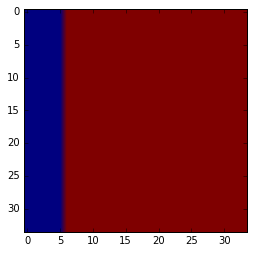

In [30]:
plt.imshow(hx>4)

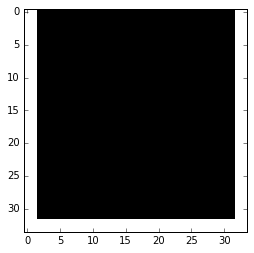

In [50]:
plt.imshow( (hy>30)|(hx<1) | (hx>30),interpolation='nearest',cmap='gray') 

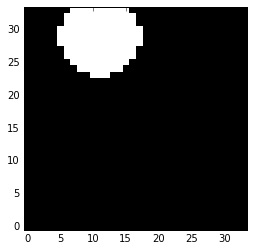

In [51]:
plt.imshow( (hx-10)**2+(hy-28)**2<6.2**2,interpolation='nearest',cmap='gray',origin='top') 

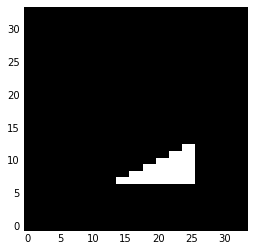

In [33]:
plt.imshow( (hy>5)&(hy<24)&(hx>10)&(hx<25)&(hx>2*hy),interpolation='nearest',cmap='gray',origin='top') 

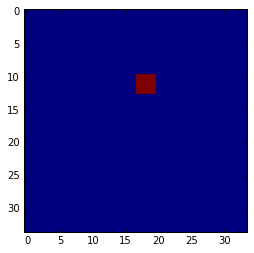

In [34]:
x0,y0,a = 15,8,4
plt.imshow( (hx>x0) & (hx<x0+a) & (hy>y0) & (hy<y0+a),interpolation='nearest') 

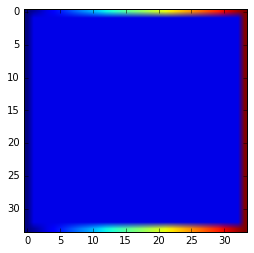

In [35]:
hx[1:-1,1:-1] = 2
plt.imshow(hx)

In [52]:
%%writefile data/ex3.py
import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTFullBBWall, NTEquilibriumVelocity
from sailfish.controller import LBSimulationController
from sailfish.lb_single import LBFluidSim

class MyBlock(Subdomain2D):

    def boundary_conditions(self, hx, hy):
        wall_map = ( (hx == self.gx-1) | (hx == 0) | (hy == 0) | (hy == self.gy-1) )
        self.set_node(wall_map, NTFullBBWall)
        x0,y0,a = 15,8,4
        square_map = (hx>x0) & (hx<x0+a) & (hy>y0) & (hy<y0+a)
        self.set_node( square_map , NTEquilibriumVelocity(( 0.1, 0.1)) )
        x0,y0,a = 15+6,8+6,4
        square_map = (hx>x0) & (hx<x0+a) & (hy>y0) & (hy<y0+a)
        self.set_node(square_map, NTFullBBWall)
        
    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0
        #sim.vx[hy == self.gy-1] = self.max_v


class MySim(LBFluidSim):
    subdomain = MyBlock

LBSimulationController(MySim).run()

Overwriting data/ex3.py


In [53]:
%%sh
export PYTHONPATH=$PWD/sailfish/
python data/ex3.py --max_iters=1000 --every=1000 \
 --lat_nx=32 --lat_ny=32 \
 --visc=0.1002 \
 --output=data/ex3 --output_format=npy

[   754  INFO Master/GPU2] Machine master starting with PID 13796 at 2016-05-18 07:34:50 UTC
[   754  INFO Master/GPU2] Simulation started with: data/ex3.py --max_iters=1000 --every=1000 --lat_nx=32 --lat_ny=32 --visc=0.1002 --output=data/ex3 --output_format=npy
[   767  INFO Master/GPU2] Sailfish version: dcc3d33d3c6fe420f78ff1af13471774ef283c74
[   767  INFO Master/GPU2] Handling subdomains: [0]
[   767  INFO Master/GPU2] Subdomain -> GPU map: {0: 0}
[   767  INFO Master/GPU2] Selected backend: cuda
[  1013  INFO Subdomain/0] Initializing subdomain.
[  1014  INFO Subdomain/0] Required memory: 
[  1014  INFO Subdomain/0] . distributions: 0 MiB
[  1014  INFO Subdomain/0] . fields: 0 MiB
[  3977  INFO Subdomain/0] Starting simulation.
[  4086  INFO Subdomain/0] Simulation completed after 1000 iterations.


In [54]:
!ls -lrta data/ex3*


-rw-r--r-- 1 marcin.kostur staff 1072 May 17 21:32 data/ex3a.py
-rw-r--r-- 1 marcin.kostur staff  945 May 18 09:33 data/ex3.py
-rw-r--r-- 1 marcin.kostur staff  586 May 18 09:34 data/ex3.subdomains
-rw-r--r-- 1 marcin.kostur staff  495 May 18 09:34 data/ex3.0.0000.npz
-rw-r--r-- 1 marcin.kostur staff 9908 May 18 09:34 data/ex3.0.1000.npz


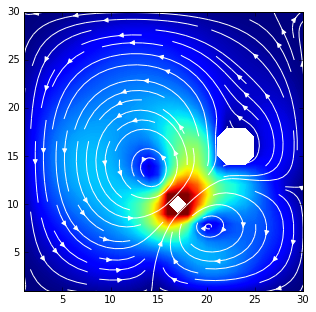

In [55]:
data = np.load("data/ex3.0.1000.npz")
vx,vy = data['v']

ny,nx = vx.shape
Y,X = np.mgrid[0:ny,0:nx]
plt.figure(figsize=(5,ny/nx*5))
plt.xlim(1,nx-2)
plt.ylim(1,ny-2)
plt.contourf(X,Y,np.sqrt(vy**2+vx**2),256)
vy[np.isnan(vy)] = 0.0
vx[np.isnan(vx)] = 0.0
plt.streamplot(X,Y,vx,vy,color='white')


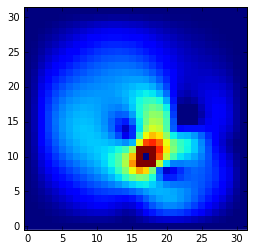

In [40]:
plt.imshow(np.sqrt(vy**2+vx**2),interpolation='none',origin='top')

In [41]:
%%writefile data/ex3a.py
import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTFullBBWall, NTEquilibriumVelocity
from sailfish.controller import LBSimulationController
from sailfish.lb_single import LBFluidSim

class MyBlock(Subdomain2D):

    def boundary_conditions(self, hx, hy):
        wall_map = ( (hx == self.gx-1) | (hx == 0) | (hy == 0) | (hy == self.gy-1) )
        self.set_node(wall_map, NTFullBBWall)
        x0,y0,a = 15,8,4
        #square_map = (hx>x0) & (hx<x0+a) & (hy>y0) & (hy<y0+a)
        square_map =(hy>10)&(hy<20)&(hx>10)&(hx<20)&(hx>2*hy)
        square_map = (hy>5)&(hy<24)&(hx>10)&(hx<25)&(hx>2*hy)
        self.set_node( square_map , NTEquilibriumVelocity(( -0.2, 0.1)) )
        x0,y0,a = 15+6,8+6,4
        square_map = (hx>x0) & (hx<x0+a) & (hy>y0) & (hy<y0+a)
        #self.set_node(square_map, NTFullBBWall)
        
    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0
        #sim.vx[hy == self.gy-1] = self.max_v


class MySim(LBFluidSim):
    subdomain = MyBlock

LBSimulationController(MySim).run()

Overwriting data/ex3a.py


In [42]:
%%sh
export PYTHONPATH=$PWD/sailfish/
python data/ex3a.py --max_iters=1000 --every=1000 \
 --lat_nx=132 --lat_ny=132 \
 --visc=0.0102 \
 --output=data/ex3 --output_format=npy

[   853  INFO Master/GPU2] Machine master starting with PID 4357 at 2016-05-17 19:32:10 UTC
[   853  INFO Master/GPU2] Simulation started with: data/ex3a.py --max_iters=1000 --every=1000 --lat_nx=132 --lat_ny=132 --visc=0.0102 --output=data/ex3 --output_format=npy
[   861  INFO Master/GPU2] Sailfish version: dcc3d33d3c6fe420f78ff1af13471774ef283c74
[   861  INFO Master/GPU2] Handling subdomains: [0]
[   861  INFO Master/GPU2] Subdomain -> GPU map: {0: 0}
[   862  INFO Master/GPU2] Selected backend: cuda
[  1095  INFO Subdomain/0] Initializing subdomain.
[  1096  INFO Subdomain/0] Required memory: 
[  1096  INFO Subdomain/0] . distributions: 1 MiB
[  1096  INFO Subdomain/0] . fields: 0 MiB
[  4640  INFO Subdomain/0] Starting simulation.
[  4750  INFO Subdomain/0] Simulation completed after 1000 iterations.


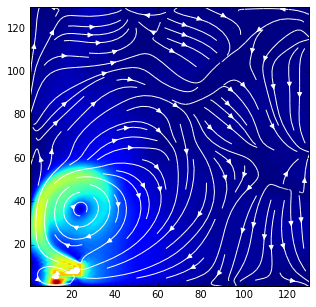

In [43]:
data = np.load("data/ex3.0.1000.npz")
vx,vy = data['v']
ny,nx = vx.shape
Y,X = np.mgrid[0:ny,0:nx]
plt.figure(figsize=(5,ny/nx*5))
plt.xlim(1,nx-2)
plt.ylim(1,ny-2)
plt.contourf(X,Y,np.sqrt(vy**2+vx**2),256)
vy[np.isnan(vy)] = 0.0
vx[np.isnan(vx)] = 0.0
plt.streamplot(X,Y,vx,vy,color='white')
